- https://numbersmithy.com/create-yolov3-using-pytorch-from-scratch-part-1/
- https://github.com/eriklindernoren/PyTorch-YOLOv3
- https://blog.deepschool.ru/cv/detection/yolo-history-part-1/

# Import

In [1]:
import os
import json

from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import MetricCollection

In [2]:
torch.set_num_threads(8)

# Utils

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def convert_box_point(box):
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

# Model

## Backbone

In [5]:
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_dim,
                out_channels=out_dim,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_dim: int,
    ):
        super().__init__()
        hidden_dim = in_dim // 2
        self.layers = nn.Sequential(
            ConvBNReLU(
                in_dim=in_dim,
                out_dim=hidden_dim,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            ConvBNReLU(
                in_dim=hidden_dim,
                out_dim=in_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.layers(x)

In [7]:
class Darknet53(nn.Module):
    def __init__(
        self,
        in_channels: int,
    ):
        super().__init__()
        self.layer_outs =  [0,  2,  5,   14,  23,  28]
        self.kernel_outs = [32, 64, 128, 256, 512, 1024]

        # (in_dim, out_dim, repeated, type, stride)
        config = (
            (3, 32, 1, 'conv', 1),
            (32, 64, 1, 'conv', 2),
            (64, 64, 1, 'residual', 1),
            (64, 128, 1, 'conv', 2),
            (128, 128, 2, 'residual', 1),
            (128, 256, 1, 'conv', 2),
            (256, 256, 8, 'residual', 1),
            (256, 512, 1, 'conv', 2),
            (512, 512, 8, 'residual', 1),
            (512, 1024, 1, 'conv', 2),
            (1024, 1024, 4, 'residual', 1),
        )

        self.features = nn.ModuleList([])
        for in_dim, out_dim, rep, layer, stride in config:
            for r in range(rep):
                if layer == 'conv':
                    self.features.append(
                        ConvBNReLU(
                            in_dim=in_dim,
                            out_dim=out_dim,
                            kernel_size=3,
                            stride=stride,
                            padding=1,
                        )
                    )
                elif layer == 'residual':
                    self.features.append(
                        ResidualBlock(
                            in_dim=in_dim,
                        )
                    )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        out = []
        for i, block in enumerate(self.features):
            x = block(x)
            if i in self.layer_outs:
                out.append(x)
        
        return out

In [8]:
darknet = Darknet53(3)

In [9]:
outs = darknet(torch.randn(32, 3, 416, 416))
[out.shape for out in outs]

[torch.Size([32, 32, 416, 416]),
 torch.Size([32, 64, 208, 208]),
 torch.Size([32, 128, 104, 104]),
 torch.Size([32, 256, 52, 52]),
 torch.Size([32, 512, 26, 26]),
 torch.Size([32, 1024, 13, 13])]

## YOLOv3

In [10]:
class YOLOHead(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hid_dims: list,
        num_classes: int,
        anchors: list,
    ):
        super().__init__()
        self.grid = torch.zeros(1)
        self.pred_dim = (5 + num_classes)
        self.anchors = torch.tensor(anchors).float().view(-1, 2)
        self.anchor_grid = self.anchors.clone().view(1, -1, 1, 1, 2)
        
        out_dim = len(anchors) * self.pred_dim
        head = [
            ConvBNReLU(
                in_dim=in_dim,
                out_dim=hid_dims[0],
                kernel_size=1,
                stride=1,
                padding=0,
            )
        ]
        for i in range(1, 6):
            ks = 1 if (i % 2) == 0 else 3
            head.append(
                ConvBNReLU(
                    in_dim=hid_dims[1] if (i % 2) == 0 else hid_dims[0],
                    out_dim=hid_dims[0] if (i % 2) == 0 else hid_dims[1],
                    kernel_size=ks,
                    stride=1,
                    padding=(ks - 1) // 2,
                )
        )
        head.append(
            nn.Conv2d(
                in_channels=hid_dims[1],
                out_channels=out_dim,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True
            )
        )
        self.head = nn.ModuleList(head)

    @staticmethod
    def _make_grid(nx: int, ny: int) -> torch.Tensor:
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()

    def postprocess(self, x: torch.Tensor, img_size: int) -> torch.Tensor:
        device = x.device
        batch_size, _, height, width = x.shape
        self.stride = img_size // x.size(2)
        x = x.view(batch_size, len(self.anchors), self.pred_dim, height, width).permute(0, 1, 3, 4, 2).contiguous()

        if not self.training:
            if self.grid.shape[2:4] != x.shape[2:4]:
                self.grid = self._make_grid(height, width).to(device)

            x[..., 0:2] = (x[..., 0:2].sigmoid() + self.grid) * self.stride  # xy
            x[..., 2:4] = torch.exp(x[..., 2:4]) * self.anchor_grid.to(device)  # wh
            x[..., 4:] = x[..., 4:].sigmoid()  # conf, cls
            x = x.view(batch_size, -1, self.pred_dim)
        return x

    def forward(self, x: torch.Tensor, img_size: int) -> tuple[torch.Tensor]:
        for i, block in enumerate(self.head):
            x = block(x)
            if i == 4:
                branch = x
        return self.postprocess(x, img_size), branch

In [11]:
class YOLOv3(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        anchors: list,
        num_classes: int,
    ):
        super().__init__()
        self.backbone = backbone
        self.anchors = anchors
        self.num_classes = num_classes

        self.yolo_large_head = YOLOHead(
            in_dim=backbone.kernel_outs[-1],
            hid_dims=backbone.kernel_outs[-2:],
            num_classes=num_classes,
            anchors=anchors[0],
        )
        self.route_to_middle = nn.Sequential(
            ConvBNReLU(
                in_dim=backbone.kernel_outs[-2],
                out_dim=backbone.kernel_outs[-3],
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.Upsample(scale_factor=2, mode="nearest"),
        )
        
        self.yolo_middle_head = YOLOHead(
            in_dim=backbone.kernel_outs[-2] + backbone.kernel_outs[-3],
            hid_dims=backbone.kernel_outs[-3:-1],
            num_classes=num_classes,
            anchors=anchors[1],
        )
        self.route_to_small = nn.Sequential(
            ConvBNReLU(
                in_dim=backbone.kernel_outs[-3],
                out_dim=backbone.kernel_outs[-4],
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.Upsample(scale_factor=2, mode="nearest"),
        )
        
        self.yolo_small_head = YOLOHead(
            in_dim=backbone.kernel_outs[-3] + backbone.kernel_outs[-4],
            hid_dims=backbone.kernel_outs[-4:-2],
            num_classes=num_classes,
            anchors=anchors[2],
        )
        self.yolo_layers = [
            self.yolo_large_head,
            self.yolo_middle_head,
            self.yolo_small_head,
        ]

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        _, _, _, out3, out4, out5 = self.backbone(x)
        large_out, large_branch = self.yolo_large_head(out5, x.size(-1))
        scaled_to_middle = self.route_to_middle(large_branch)

        middle = torch.cat([scaled_to_middle, out4], dim=1)
        middle_out, middle_branch = self.yolo_middle_head(middle, x.size(-1))
        scaled_to_small = self.route_to_small(middle_branch)

        small = torch.cat([scaled_to_small, out3], dim=1)
        small_out, _ = self.yolo_small_head(small, x.size(-1))

        return (large_out, middle_out, small_out)

In [12]:
yolo = YOLOv3(
    backbone=Darknet53(3),
    anchors=[
        [[116, 90], [156, 198], [373, 326]],
        [[30, 61], [62, 45], [59, 119]],
        [[10, 13], [16, 30], [33, 23]]
    ],
    num_classes=80,
)
yolo_outs = yolo(torch.randn(4, 3, 416, 416))
[out.shape for out in yolo_outs]

[torch.Size([4, 3, 13, 13, 85]),
 torch.Size([4, 3, 26, 26, 85]),
 torch.Size([4, 3, 52, 52, 85])]

In [13]:
count_parameters(yolo)

61949149

# NMS

https://github.com/pytorch/vision/issues/942?ysclid=m80evb025u198350886

In [14]:
trans = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((416, 416)),
        v2.RandomHorizontalFlip(p=0.3),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [15]:
img_file = '../data/coco2017/val2017/000000011197.jpg'
img = Image.open(img_file)

batch = trans(img).unsqueeze(0)

In [16]:
yolo.eval()
print()

In [17]:
def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [18]:
def xyxy2xywh(x):
    """Converts nx4 bounding boxes from corners [x1, y1, x2, y2] to center format [x, y, w, h]."""
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

In [19]:
def non_max_suppression(
    prediction: torch.Tensor,
    conf_threshold: float,
    iou_threshold: float,
    max_detections: int = 1_000
) -> list[torch.Tensor]:
    # predictions = [batch_size, num_anchors, 5 + num_classes]
    batch_size = prediction.size(0)
    num_classes = prediction.size(2) - 5
    
    output = [torch.zeros((0, 6), device=prediction.device)] * batch_size
    for idx, x in enumerate(prediction):
        # confidence
        x = x[x[:, 4] > conf_threshold]
        if not len(x):
            continue

        # conf = obj_conf * cls_conf
        x[:, 5:] *= x[:, 4:5]
        # (cx, cy, w, h) -> (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        i, j = torch.where(x[:, 5:] > conf_threshold)
        x = torch.cat([
            box[i],
            x[i, j + 5, None],
            j[:, None].float(),
        ], dim=1)

        # no boxes
        if not len(x):  
            continue

        boxes, scores = x[:, :4], x[:, 4]
        nms_ids = torchvision.ops.nms(boxes, scores, iou_threshold)
        
        # limit detections
        if nms_ids.shape[0] > max_detections:
            nms_ids = nms_ids[:max_detections]
        output[idx] = x[nms_ids]
    
    return output

In [20]:
def detect(
    prediction: torch.Tensor,
    conf_threshold: float,
    iou_threshold: float,
    max_detections: int = 100
) -> list[dict[str, torch.Tensor]]:
    """
    :param prediction: tensor [batch_size, num_anchors, 5 + num_classes]
    :param conf_threshold:
    :param iou_threshold:
    :param max_detections:
    """
    batch_size = prediction.size(0)
    detections = []
    boxes = non_max_suppression(prediction, conf_threshold, iou_threshold, max_detections)

    for i in range(batch_size):
        detections.append({
            'boxes': boxes[i][:, :4],
            'scores': boxes[i][:, 4],
            'labels': boxes[i][:, 5].int(),
        })
    return detections

In [21]:
preds = yolo(batch)
preds = torch.cat(preds, dim=1)
preds.shape

torch.Size([1, 10647, 85])

In [22]:
boxes = non_max_suppression(preds, 0.2, 0.5, 100)

In [23]:
boxes[0].shape

torch.Size([100, 6])

In [24]:
boxes[0][:, -1]

tensor([72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72.,
        72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 28., 72., 23., 29., 23., 23., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        23., 29.], grad_fn=<SelectBackward0>)

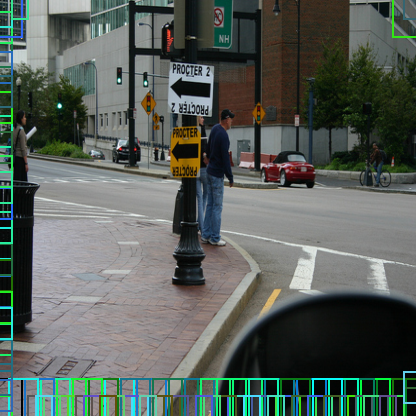

In [25]:
ind = -1
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0]),
    boxes=boxes[0][:, :4],
    width=2,
)

v2.ToPILImage()(a)

# Dataset

In [26]:
with open('../data/coco2017/annotations/instances_train2017.json', 'r') as file:
    train_annot = json.load(file)
with open('../data/coco2017/annotations/instances_val2017.json', 'r') as file:
    valid_annot = json.load(file)

In [27]:
class COCODataset(Dataset):
    def __init__(self, annot, path, transforms = None):
        self.annot = annot
        self.path = path

        class_names = dict()
        for cat in train_annot['categories']:
            class_names[cat['id']] = cat['name']

        images = dict()
        for img in annot['images']:    
            images[img['id']] = {
                'file_name': img['file_name'],
                'height': img['height'],
                'width': img['width'],
                'boxes': [],
                'labels': [],
                'classes': [],
            }

        for an in annot['annotations']:
            # check width and height box gt 0
            if (an['bbox'][2] > 0) and (an['bbox'][3] > 0):
                images[an['image_id']]['boxes'].append(convert_box_point(an['bbox']))
                images[an['image_id']]['labels'].append(an['category_id'])
                images[an['image_id']]['classes'].append(class_names[an['category_id']])

        broken = []
        for k, v in images.items():
            if len(v['boxes']) + len(v['labels']) < 1:
                broken.append(k)
            if len(v['boxes']) != len(v['labels']):
                broken.append(k)
        print(len(broken))

        for b in broken:
            del(images[b])

        self.objects = images
        self.image_idx = {i: k for i, k in enumerate(images.keys())}
        self.class_names = class_names
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_idx[idx]
        
        image = Image.open(
            os.path.join(self.path, self.objects[image_id]['file_name'])
        ).convert('RGB')

        labels = torch.tensor(self.objects[image_id]['labels'], dtype=torch.int64)        
        
        boxes = tv_tensors.BoundingBoxes(
            self.objects[image_id]['boxes'],
            format="XYXY",
            canvas_size=(image.height, image.width),  # Height and width
        )

        categories = self.objects[image_id]['classes']
        
        target = {
            'boxes': boxes,
            # start class label from zero
            'labels': labels - 1,
            'categories': categories,
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target

    def __len__(self) -> int:
        return len(self.objects)

In [28]:
train_dataset = COCODataset(train_annot, '../data/coco2017/train2017/', trans)
valid_dataset = COCODataset(valid_annot, '../data/coco2017/val2017/', trans)

1021
48


In [29]:
def collate_fn(batch):
    images = []
    targets = {'boxes': [], 'labels': [], 'categories': []}
    
    for row in batch:
        image, target = row
        images.append(image)
        height, width = target['boxes'].canvas_size
        targets['boxes'].append(target['boxes'])
        targets['labels'].append(target['labels'])
        targets['categories'].append(target['categories'])
    
    return torch.stack(images, dim=0), targets

In [30]:
batch_size = 3
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=True,
    num_workers=12,
    # persistent_workers=True,
    # pin_memory=True,
)
val_loader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=12,
    # persistent_workers=True,
    # pin_memory=True,
)

In [31]:
yolo.eval()
print()

In [32]:
for batch in val_loader:
    break

In [33]:
torch.cat(yolo(batch[0]), dim=1).shape

torch.Size([3, 10647, 85])

In [34]:
nms_out = non_max_suppression(torch.cat(yolo(batch[0]), dim=1), 0.3, 0.5, 10)

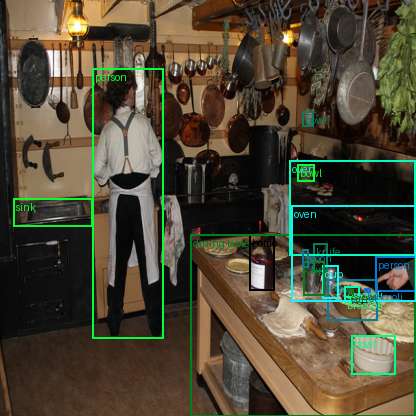

In [35]:
ind = 0
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=batch[1]['boxes'][ind],
    labels=batch[1]['categories'][ind],
    width=2,
)

v2.ToPILImage()(a)

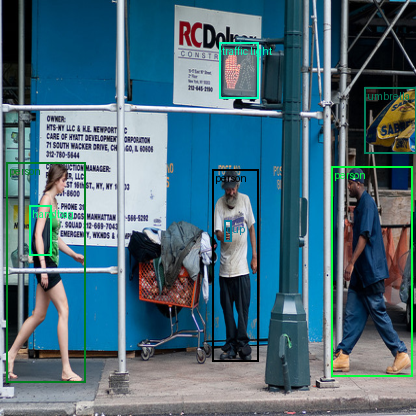

In [36]:
ind = 2
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=batch[1]['boxes'][ind],
    labels=batch[1]['categories'][ind],
    width=2,
)

v2.ToPILImage()(a)

# Loss

In [37]:
class MultiScaleLoss(nn.Module):
    def __init__(
        self,
        num_classes: int,
        device: str,
        anchor_threshold: float = 4.0
    ):
        super().__init__()
        self.num_classes = num_classes
        self.device = device
        self.anchor_threshold = anchor_threshold

    def forward(
        self,
        x: list[torch.Tensor],
        labels: torch.Tensor,
        yolo_layers: list[nn.Module],
    ):
        """
        :param x: list of model raw output tensors like [batch_size, anchor, cy, cx, 5 + num_classes]
        :param labels: ground true bounding boxes like [batch_ind, x, y, w, h, label]. All coordinates are fractional offsets
        :param yolo_layers:
        """
        num_objects = len(labels)
        num_predicts = 0
        for scale in x:
            batch_size, n_anchors, h, w, _ = scale.shape
            num_predicts += n_anchors * h * w

        obj_weights = torch.tensor([(num_predicts - num_objects) / num_objects / 2], device=self.device)
        obj_bce = nn.BCEWithLogitsLoss(pos_weight=obj_weights)
        cls_bce = nn.CrossEntropyLoss()

        loss_box = torch.zeros(1, device=self.device)
        loss_obj = torch.zeros(1, device=self.device)
        loss_cls = torch.zeros(1, device=self.device)

        for i, (scale, yolo_layer) in enumerate(zip(x, yolo_layers)):
            batch_size, num_anchors, cy, cx, pred_dim = scale.shape
            stride = float(yolo_layer.stride)

            # image coordinate -> feature map coordinate (p_w, p_h)
            anchors = (yolo_layer.anchors / stride).float().to(self.device)
            # feature map sizes
            grid_size = torch.tensor([cx, cy]).float().to(self.device)
            
            # convert to feature map scale
            wh_true = labels[:, 3:5] * grid_size

            # find matches between labels and anchors
            # ratio = [num_objects, num_anchors, 2]
            ratio = wh_true[:, None, :] / anchors[None, :, :]
            # The best matches are those with smallest absolute (width + height) ratios from 1.0
            ratio = torch.abs(ratio - 1).sum(2)
            ratio = torch.min(ratio, dim=1)

            # label_idx is a tensor of indices, denoting those ground truth labels
            # that found associations with any anchor_box in this scale
            label_idx = ratio[0] < self.anchor_threshold

            # anchor_idx is a tensor of indices, denoting the anchor boxes in this scale
            # that were associated with any ground truth labels
            anchor_idx = ratio[1][label_idx]

            # matched batch indices
            batch_idx = labels[label_idx, 0].long()

            # get cell coordinates of labeled objects
            xy_true = labels[label_idx, 1:3] * grid_size
            xy_idx = torch.floor(xy_true).long()
            x_idx = xy_idx[:, 0].clamp(0, int(grid_size[0]) - 1)
            y_idx = xy_idx[:, 1].clamp(0, int(grid_size[1]) - 1)

            # These define the ground truth – anchor box associations - [batch_idx, anchor_idx, y_idx, x_idx]

            # Get confidence
            obj_true = torch.zeros(scale.shape[:-1], device=self.device).float()
            obj_pred = scale[..., 4]

            if len(batch_idx) > 0:
                # subtract the cell coordinates (cx, cy) and get the relative offsets 
                relative_xy_true = xy_true - xy_idx
                wh_true = labels[label_idx, 3:5] * grid_size

                # [sigmoid(t_x), sigmoid(t_y)]
                xy_pred = torch.sigmoid(scale[batch_idx, anchor_idx, y_idx, x_idx, 0:2])

                # [exp(t_w), exp(t_h)]
                wh_pred = torch.exp(scale[batch_idx, anchor_idx, y_idx, x_idx, 2:4]) * anchors[anchor_idx, :]
                wh_pred = wh_pred.clamp(0, grid_size.max())
        
                # compute IoUs
                box_pred = torch.cat([xy_pred, wh_pred], dim=1)
                box_true = torch.cat([relative_xy_true, wh_true], dim=1)
                
                iou = torchvision.ops.box_iou(
                    xywh2xyxy(box_pred),
                    xywh2xyxy(box_true),
                ).diag()
                # Update Localization Loss
                loss_box += (1.0 - iou).mean()
                
                # set iou as a target for confidence loss
                obj_true[batch_idx, anchor_idx, y_idx, x_idx] = iou.detach().clamp(0).type(obj_true.dtype)

                # get classification logits
                cls_pred = scale[batch_idx, anchor_idx, y_idx, x_idx, 5:]
                # cls_one_hot_true = F.one_hot(labels[label_idx, -1].long(), self.num_classes).float().to(self.device)

                # Update Classification Loss
                loss_cls += cls_bce(cls_pred, labels[label_idx, -1].long())
            
            # Update Confidence Loss
            loss_obj += obj_bce(obj_pred, obj_true)

            self.loss = loss_box + loss_obj + loss_cls * 0.5
        return self.loss

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [38]:
total_losses = []

In [39]:
class YoloLightning(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        t_max,
    ):
        super().__init__()

        self.model = model
        self.criterion = criterion
        self.t_max = t_max

        metric = MetricCollection({
            'map': MeanAveragePrecision(box_format='xyxy', iou_type='bbox'),
        })
        self.train_metric = metric.clone(prefix='train/')
        self.valid_metric = metric.clone(prefix='valid/')

        self.save_hyperparameters(ignore=['model', 'criterion'])

    def forward(self, x):
        return self.model(x)
    
    def evaluate(self, batch, metric_func=None):
        images, labels = batch

        targets = []
        for i, (box, label) in enumerate(zip(labels['boxes'], labels['labels'])):
            target = torch.hstack([
                torch.full((len(box), 1), i, device=images.device),
                xyxy2xywh(box / box.canvas_size[0]),
                label.view(-1, 1),
            ])
            targets.append(target)
        targets = torch.vstack(targets)

        output = self.model(images)
        
        loss = self.criterion(
            output,
            targets,
            self.model.yolo_layers,
        )

        return loss
    
    def training_step(self, batch, batch_idx):
        train_loss = self.evaluate(batch)
        self.log(
            'train_loss',
            train_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        total_losses.append(train_loss.item())

        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log(
            'lr',
            lr,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        device = images.device

        targets = []
        for i, (box, label) in enumerate(zip(labels['boxes'], labels['labels'])):
            target = torch.hstack([
                torch.full((len(box), 1), i, device=device),
                xyxy2xywh(box / box.canvas_size[0]),
                label.view(-1, 1),
            ])
            targets.append(target)
        targets = torch.vstack(targets)

        output = torch.cat(self.model(images), dim=1)
        
        preds = detect(output, 0.5, 0.6, 15)
        target = []
        for b, l in zip(labels['boxes'], labels['labels']):
            target.append({
                'boxes': b.to(device),
                'labels': l.to(device),
            })
        metric = self.valid_metric(preds, target)
        
        self.log(
            'valid_map_50',
            metric['valid/map_50'],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        return metric
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=0.001,
            weight_decay=0.0005,
        )
        return optimizer

In [40]:
yolo = YOLOv3(
    backbone=Darknet53(3),
    anchors=[
        [[116, 90], [156, 198], [373, 326]],
        [[30, 61], [62, 45], [59, 119]],
        [[10, 13], [16, 30], [33, 23]]
    ],
    num_classes=90,
)

In [41]:
criterion = MultiScaleLoss(90, 'cuda')

In [42]:
torch.set_float32_matmul_precision('medium')

In [ ]:
num_epochs = 10

trainer = pl.Trainer(
    accelerator='cuda',
    max_epochs=num_epochs,
    accumulate_grad_batches=36,
    precision='bf16-mixed',
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=1,
    use_distributed_sampler=True,
)

model = YoloLightning(
    model=yolo,
    criterion=criterion,
    t_max=int(len(train_dataset) / batch_size + 1) * num_epochs
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | YOLOv3           | 62.0 M | train
1 | criterion    | MultiScaleLoss   | 0      | train
2 | train_metric | MetricCollection | 0      | train
3 | valid_metric | MetricCollection | 0      | train
----------------------------------------------------------
62.0 M    Trainable params
0         Non-trainable params
62.0 M    Total params
248.012   Total estimated model params size (MB)
427       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [44]:
import seaborn as sns

<Axes: >

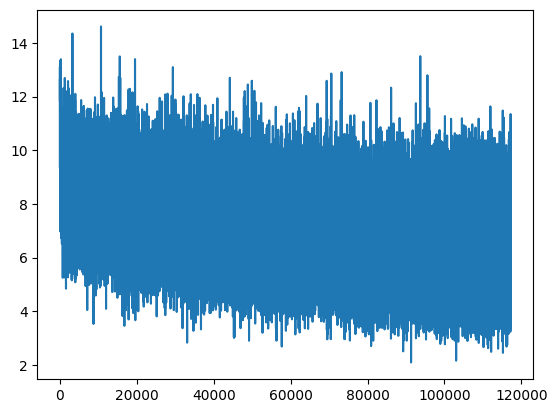

In [45]:
sns.lineplot(total_losses)

In [46]:
for batch in val_loader:
    break

In [47]:
yolo.to('cuda').eval()
print()

In [48]:
nms_out = non_max_suppression(torch.cat(yolo(batch[0].to('cuda')), dim=1), 0.5, 0.6, 10)
nms_out

[tensor([[237.3766,  67.5573, 308.2412, 351.9001,   0.9805,   0.0000],
         [267.2893,  63.3996, 339.1396, 354.9630,   0.9789,   0.0000],
         [125.8305, 239.2404, 174.8485, 295.7601,   0.9727,  46.0000],
         [  6.9378, 292.2584,  83.2856, 377.3665,   0.9720,  50.0000],
         [ 47.3960, 278.5475, 107.5893, 325.4097,   0.9630,  50.0000],
         [161.5657, 105.6662, 195.9081, 179.6461,   0.9620,  43.0000],
         [212.8738,  86.3133, 276.1005, 333.4149,   0.9603,   0.0000],
         [  3.0364, 271.1272,  92.2339, 343.5974,   0.9589,  50.0000],
         [329.9131,  13.0168, 346.5251,  42.3210,   0.9554,  36.0000],
         [134.1507, 235.2860, 212.2785, 301.2058,   0.9539,  50.0000]],
        device='cuda:0', grad_fn=<IndexBackward0>),
 tensor([[9.9066e+01, 3.1780e+02, 1.8755e+02, 4.0095e+02, 9.9585e-01, 5.4000e+01],
         [3.2817e-01, 9.9733e+01, 1.6955e+01, 1.3806e+02, 9.6167e-01, 0.0000e+00],
         [3.1487e+02, 1.0532e+02, 3.3184e+02, 1.2285e+02, 9.5180e-01, 3

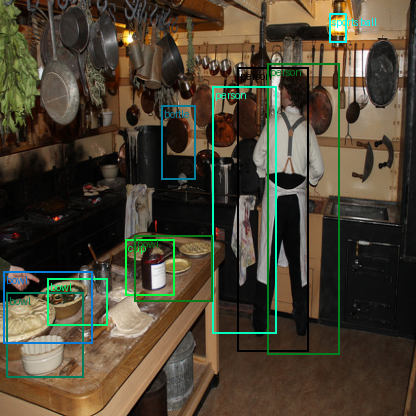

In [55]:
ind = 0
cats = [
    train_dataset.class_names[i+1] for i in nms_out[ind][:, -1].detach().cpu().int().numpy().tolist()
]
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=nms_out[ind][:, :4],
    labels=cats,
    width=2,
)

v2.ToPILImage()(a)

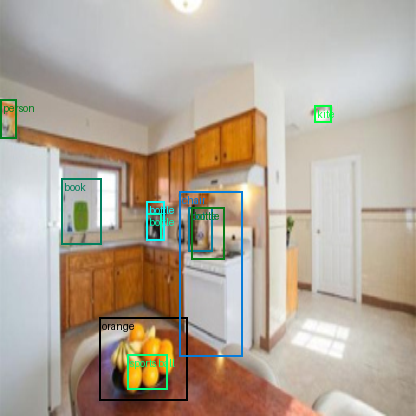

In [56]:
ind = 1
cats = [
    train_dataset.class_names[i+1] for i in nms_out[ind][:, -1].detach().cpu().int().numpy().tolist()
]
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=nms_out[ind][:, :4],
    labels=cats,
    width=2,
)

v2.ToPILImage()(a)

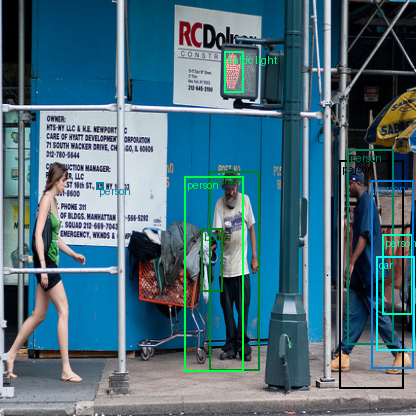

In [57]:
ind = 2
cats = [
    train_dataset.class_names[i+1] for i in nms_out[ind][:, -1].detach().cpu().int().numpy().tolist()
]
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=nms_out[ind][:, :4],
    labels=cats,
    width=2,
)

v2.ToPILImage()(a)